In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data.csv",parse_dates=["posted","scraped"])

# df = df.loc[df.test==False]

df["age"] = (df.scraped - df.posted).dt.total_seconds()//3600
df["weekday"] = df.posted.dt.day_name()
df["weekday_number"] = df.posted.dt.dayofweek
df["hour"] = df.posted.dt.hour
df["date"] = pd.to_datetime(df.posted.dt.date)
df["year"] = df.posted.dt.year
df["month"] = df.posted.dt.month
df["yrmnth"] = (df.year-2021)*12 + df.month
df["target"] = np.log(df.upvotes+1)

df["fhost"] = df.url.apply(lambda x: "imgur" if "imgur" in x else "reddit")
df["format"] = df.url.apply(lambda x: x.split(".")[-1])



sub = pd.read_csv("subscribers.csv",parse_dates=["timestamp"])

sub["date"] = sub.timestamp.dt.date

sub = sub.pivot(index="date",columns=["subreddit"],values="subscribers")

# Correcting any missing dates
daterange = pd.date_range(start=df.date.min(),end=df.date.max(),freq="D")
sub = sub.reindex(daterange)

# Filling in the new NULL values
sub.interpolate(method="linear",inplace=True)
sub.bfill(inplace=True)


# Adding the date back into the columns so we can melt the updated dataset
sub["date"] = pd.to_datetime(sub.index)
sub = pd.melt(sub,id_vars="date")


# Joining the two dataframes together
df = df.merge(sub.rename(columns={"value":"subscribers"}),how="left",on=["date","subreddit"])





stage1 = df.groupby(["date","subreddit","category","hour"],as_index=False).agg({"upvotes":"count"}).rename(columns={"upvotes":"competition_subreddit"})
stage2 = stage1.groupby(["date","hour","category"],as_index=False).agg({"competition_subreddit":"sum"}).rename(columns={"competition_subreddit":"competition_category"})
stage3 = stage2.groupby(["date","hour"],as_index=False).agg({"competition_category":"sum"}).rename(columns={"competition_category":"competition_total"})



df = df.merge(stage1,how="left",on=["date","hour","subreddit","category"]).merge(stage2,how="left",on=["date","hour","category"]).merge(stage3,how="left",on=["date","hour"])

df.head()



,fname,url,category,subreddit,title,description,upvotes,posted,scraped,niche,...,year,month,yrmnth,target,fhost,format,subscribers,competition_subreddit,competition_category,competition_total
0,cgptykrzcez71.jpg,https://i.redd.it/cgptykrzcez71.jpg,cats,catpictures,Caturday morning TV 😺,NaN,247.0,2021-11-13 11:22:11,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,5.513429,reddit,jpg,142344.0,1,5,17
1,EGjVMqx.jpg,https://i.imgur.com/EGjVMqx.jpg,cats,catpictures,Round loaf!,NaN,24.0,2021-11-13 02:23:31,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,3.218876,imgur,jpg,142344.0,1,2,4
2,y45936kis8z71.jpg,https://i.redd.it/y45936kis8z71.jpg,cats,catpictures,Taken over fall wreath,NaN,427.0,2021-11-12 16:38:49,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,6.059123,reddit,jpg,142344.0,2,7,21
3,irl2nzyro8z71.jpg,https://i.redd.it/irl2nzyro8z71.jpg,cats,catpictures,"My kitten, Topaz!",NaN,196.0,2021-11-12 16:17:45,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,5.283204,reddit,jpg,142344.0,2,7,21
4,vlsh4hijg8z71.jpg,https://i.redd.it/vlsh4hijg8z71.jpg,cats,catpictures,My Tom is not impressed having to wait for the...,NaN,620.0,2021-11-12 15:31:23,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,6.431331,reddit,jpg,142344.0,1,4,19


In [3]:
df.columns

Index(['fname', 'url', 'category', 'subreddit', 'title', 'description',
       'upvotes', 'posted', 'scraped', 'niche', 'test', 'age', 'weekday',
       'weekday_number', 'hour', 'date', 'year', 'month', 'yrmnth', 'target',
       'fhost', 'format', 'subscribers', 'competition_subreddit',
       'competition_category', 'competition_total'],
      dtype='object')

In [95]:
tsdf = df.groupby(["date","month","year","weekday","subreddit","category"],as_index=False).agg({"target":"mean","subscribers":"mean","url":"count"}).sort_values("date")

In [96]:
tsdf["subscribers_logged"] = np.log(tsdf["subscribers"])

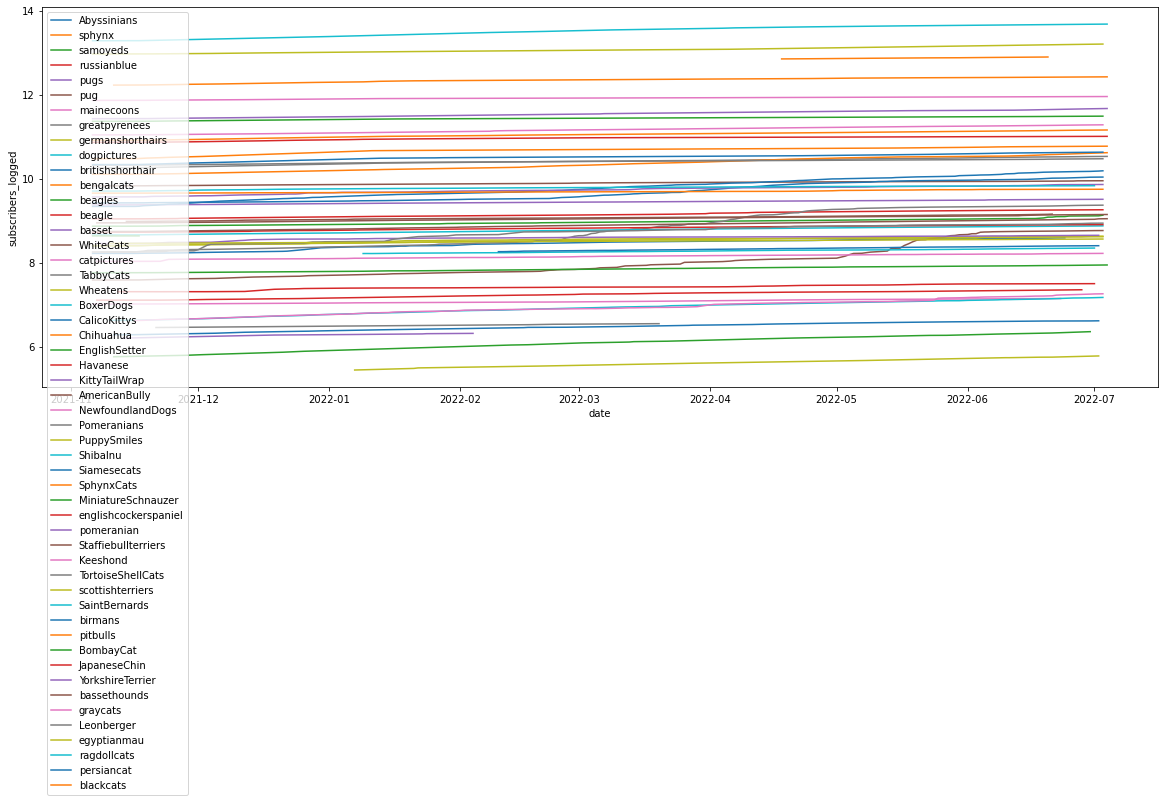

In [23]:
fig,ax = plt.subplots(figsize=(20,7))

for sub in tsdf.subreddit.unique():
    
    sns.lineplot(data=tsdf[tsdf.subreddit==sub],ax=ax,x="date",y="subscribers_logged",label=sub)
    
#     plt.plot(tsdf[tsdf.subreddit==sub].date,np.log(tsdf[tsdf.subreddit==sub].subscribers))

In [97]:
growth = tsdf.groupby(["subreddit","category"],as_index=False).agg({"subscribers":["min","max"]})

In [46]:
growth.head()

subreddit category subscribers         
                                  min      max
0    Abyssinians     cats      3718.0   5387.0
1  AmericanBully     dogs      6256.0   8494.0
2      BombayCat     cats       317.0    576.0
3      BoxerDogs     dogs      5781.0   7160.0
4   CalicoKittys     cats     11384.0  26586.0

In [98]:
growth["growth"] = (growth["subscribers"]["max"] - growth["subscribers"]["min"])/(growth["subscribers"]["min"])

growth

subreddit category subscribers              growth
                                          min       max          
0            Abyssinians     cats      3718.0    5387.0  0.448897
1          AmericanBully     dogs      6256.0    8494.0  0.357737
2              BombayCat     cats       317.0     576.0  0.817035
3              BoxerDogs     dogs      5781.0    7160.0  0.238540
4           CalicoKittys     cats     11384.0   26586.0  1.335383
5              Chihuahua     dogs     54956.0   70281.0  0.278859
6          EnglishSetter     dogs      2343.0    2821.0  0.204012
7               Havanese     dogs      6168.0    7386.0  0.197471
8           JapaneseChin     dogs      1491.0    1808.0  0.212609
9               Keeshond     dogs      3073.0    3718.0  0.209893
10         KittyTailWrap     cats     14278.0   19185.0  0.343676
11            Leonberger     dogs       636.0     697.0  0.095912
12    MiniatureSchnauzer     dogs      5641.0    5643.0  0.000355
13      NewfoundlandDogs     dogs      1113.0    1269.0  0.140162
14           Pomeranians     dogs     30400.0   35420.0  0.165132
15           PuppySmiles     dogs    429566.0  544324.0  0.267149
16         SaintBernards     dogs       755.0    1302.0  0.724503
17              ShibaInu     dogs     16410.0   18640.0  0.135893
18           Siamesecats     cats     30819.0   41449.0  0.344917
19            SphynxCats     cats     15617.0   17131.0  0.096946
20   Staffiebullterriers     dogs      7692.0    9388.0  0.220489
21             TabbyCats     cats      3845.0   11725.0  2.049415
22     TortoiseShellCats     cats      3848.0    7640.0  0.985447
23              Wheatens     dogs      4440.0    5525.0  0.244369
24             WhiteCats     cats      1972.0    6405.0  2.247972
25      YorkshireTerrier     dogs       494.0     553.0  0.119433
26                basset     dogs     11799.0   13484.0  0.142809
27          bassethounds     dogs      7955.0    9477.0  0.191326
28                beagle     dogs     52367.0   60405.0  0.153494
29               beagles     dogs      7105.0    9238.0  0.300211
30            bengalcats     cats     24492.0   40937.0  0.671444
31               birmans     cats       536.0     746.0  0.391791
32             blackcats     cats    382091.0  400057.0  0.047020
33      britishshorthair     cats     12374.0   22900.0  0.850655
34           catpictures     cats    142344.0  155965.0  0.095691
35           dogpictures     dogs    589141.0  875863.0  0.486678
36           egyptianmau     cats       231.0     323.0  0.398268
37  englishcockerspaniel     dogs      1220.0    1563.0  0.281148
38      germanshorthairs     dogs      4490.0    5605.0  0.248330
39              graycats     cats       751.0    1420.0  0.890812
40         greatpyrenees     dogs     28519.0   37471.0  0.313896
41            mainecoons     cats     62570.0   79514.0  0.270801
42            persiancat     cats      3874.0    4465.0  0.152555
43              pitbulls     dogs    204760.0  249266.0  0.217357
44            pomeranian     dogs      4708.0    5718.0  0.214528
45                   pug     dogs     18588.0   20978.0  0.128578
46                  pugs     dogs     91994.0  117236.0  0.274387
47           ragdollcats     cats      3704.0    4220.0  0.139309
48           russianblue     cats      8456.0   10511.0  0.243023
49              samoyeds     dogs     86323.0   97732.0  0.132166
50      scottishterriers     dogs      4718.0    5234.0  0.109368
51                sphynx     cats     35469.0   47780.0  0.347092

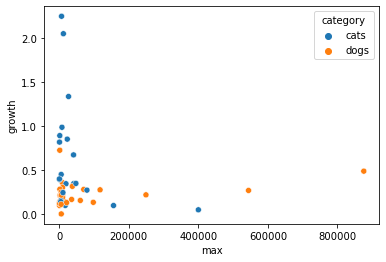

In [55]:
sns.scatterplot(data=growth,x="max",y="growth",hue="category");

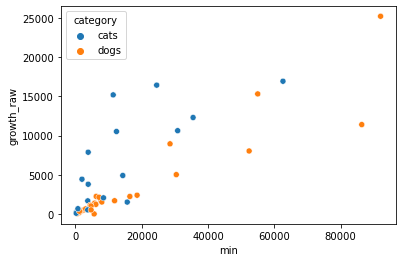

In [57]:
sns.scatterplot(data=growth[growth["min"]<100000],x="min",y="growth_raw",hue="category");

<AxesSubplot:xlabel='category', ylabel='growth'>

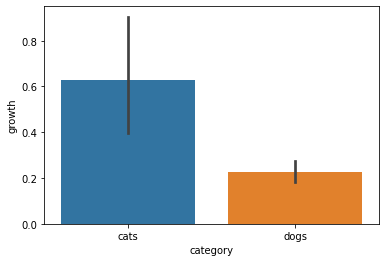

In [60]:
sns.barplot(data=growth,x="category",y="growth")

In [42]:
growth.sort_values("min")

subreddit subscribers              growth       max       min  \
                                 min       max                                 
36           egyptianmau       231.0     323.0  0.398268     323.0     231.0   
2              BombayCat       317.0     576.0  0.817035     576.0     317.0   
25      YorkshireTerrier       494.0     553.0  0.119433     553.0     494.0   
31               birmans       536.0     746.0  0.391791     746.0     536.0   
11            Leonberger       636.0     697.0  0.095912     697.0     636.0   
39              graycats       751.0    1420.0  0.890812    1420.0     751.0   
16         SaintBernards       755.0    1302.0  0.724503    1302.0     755.0   
13      NewfoundlandDogs      1113.0    1269.0  0.140162    1269.0    1113.0   
37  englishcockerspaniel      1220.0    1563.0  0.281148    1563.0    1220.0   
8           JapaneseChin      1491.0    1808.0  0.212609    1808.0    1491.0   
24             WhiteCats      1972.0    6405.0  2.247972    6405.0    1972.0   
6          EnglishSetter      2343.0    2821.0  0.204012    2821.0    2343.0   
9               Keeshond      3073.0    3718.0  0.209893    3718.0    3073.0   
47           ragdollcats      3704.0    4220.0  0.139309    4220.0    3704.0   
0            Abyssinians      3718.0    5387.0  0.448897    5387.0    3718.0   
21             TabbyCats      3845.0   11725.0  2.049415   11725.0    3845.0   
22     TortoiseShellCats      3848.0    7640.0  0.985447    7640.0    3848.0   
42            persiancat      3874.0    4465.0  0.152555    4465.0    3874.0   
23              Wheatens      4440.0    5525.0  0.244369    5525.0    4440.0   
38      germanshorthairs      4490.0    5605.0  0.248330    5605.0    4490.0   
44            pomeranian      4708.0    5718.0  0.214528    5718.0    4708.0   
50      scottishterriers      4718.0    5234.0  0.109368    5234.0    4718.0   
12    MiniatureSchnauzer      5641.0    5643.0  0.000355    5643.0    5641.0   
3              BoxerDogs      5781.0    7160.0  0.238540    7160.0    5781.0   
7               Havanese      6168.0    7386.0  0.197471    7386.0    6168.0   
1          AmericanBully      6256.0    8494.0  0.357737    8494.0    6256.0   
29               beagles      7105.0    9238.0  0.300211    9238.0    7105.0   
20   Staffiebullterriers      7692.0    9388.0  0.220489    9388.0    7692.0   
27          bassethounds      7955.0    9477.0  0.191326    9477.0    7955.0   
48           russianblue      8456.0   10511.0  0.243023   10511.0    8456.0   
4           CalicoKittys     11384.0   26586.0  1.335383   26586.0   11384.0   
26                basset     11799.0   13484.0  0.142809   13484.0   11799.0   
33      britishshorthair     12374.0   22900.0  0.850655   22900.0   12374.0   
10         KittyTailWrap     14278.0   19185.0  0.343676   19185.0   14278.0   
19            SphynxCats     15617.0   17131.0  0.096946   17131.0   15617.0   
17              ShibaInu     16410.0   18640.0  0.135893   18640.0   16410.0   
45                   pug     18588.0   20978.0  0.128578   20978.0   18588.0   
30            bengalcats     24492.0   40937.0  0.671444   40937.0   24492.0   
40         greatpyrenees     28519.0   37471.0  0.313896   37471.0   28519.0   
14           Pomeranians     30400.0   35420.0  0.165132   35420.0   30400.0   
18           Siamesecats     30819.0   41449.0  0.344917   41449.0   30819.0   
51                sphynx     35469.0   47780.0  0.347092   47780.0   35469.0   
28                beagle     52367.0   60405.0  0.153494   60405.0   52367.0   
5              Chihuahua     54956.0   70281.0  0.278859   70281.0   54956.0   
41            mainecoons     62570.0   79514.0  0.270801   79514.0   62570.0   
49              samoyeds     86323.0   97732.0  0.132166   97732.0   86323.0   
46                  pugs     91994.0  117236.0  0.274387  117236.0   91994.0   
34           catpictures    142344.0  155965.0  0.095691  155965.0  142344.0   
43             

In [99]:
growth["max"] = growth["subscribers"]["max"]

In [100]:
growth["min"] = growth["subscribers"]["min"]

In [101]:
growth["growth_raw"] = growth["max"] - growth["min"]

<AxesSubplot:xlabel='subreddit', ylabel='growth'>

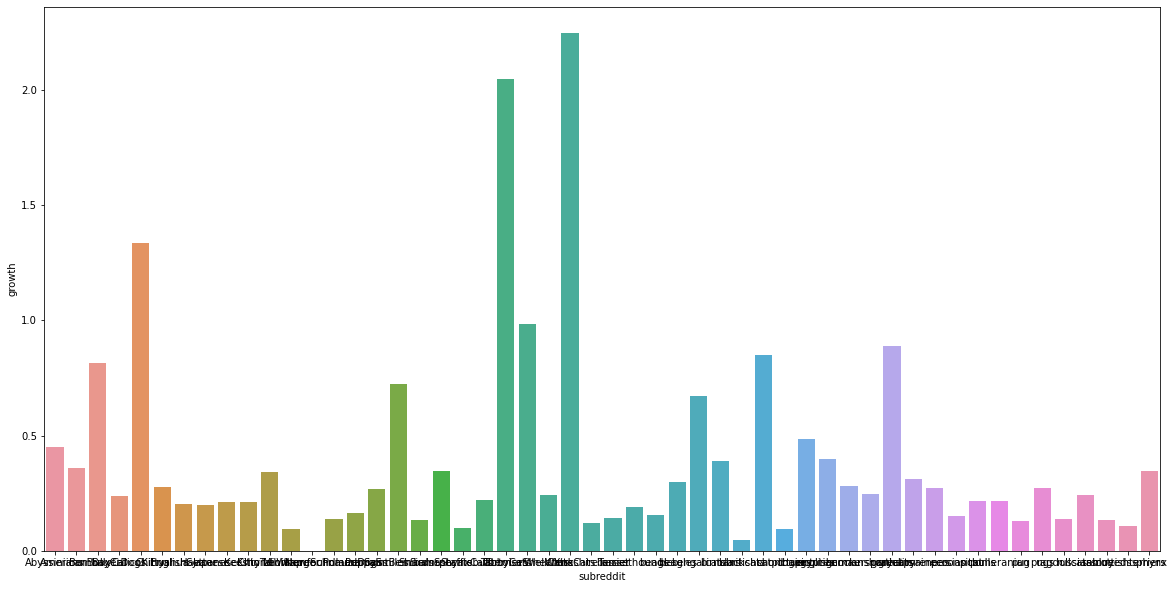

In [32]:
fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(data=growth,x="subreddit",y="growth")

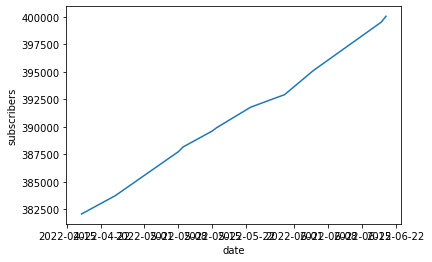

In [16]:
sns.lineplot(data=tsdf[tsdf.subreddit==sub],x="date",y="subscribers");

In [15]:
tsdf[tsdf.subreddit==""]

,date,month,year,weekday,subreddit,target,subscribers


In [66]:
tsdf.set_index("date",inplace=True)

In [61]:
tsdf.head()

,date,month,year,weekday,subreddit,category,target,subscribers,subscribers_logged
0,2021-11-06,11,2021,Saturday,Abyssinians,cats,4.530340,3718.0,8.220941
32,2021-11-06,11,2021,Saturday,sphynx,cats,4.430509,35469.0,10.476414
31,2021-11-06,11,2021,Saturday,samoyeds,dogs,5.428035,86323.0,11.365851
30,2021-11-06,11,2021,Saturday,russianblue,cats,4.795791,8456.0,9.042632
29,2021-11-06,11,2021,Saturday,pugs,dogs,4.351765,91994.0,11.429479


<AxesSubplot:xlabel='date', ylabel='subscribers_logged'>

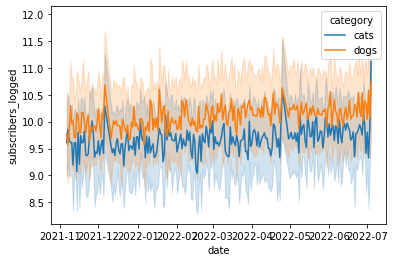

In [63]:
sns.lineplot(data=tsdf,x="date",y="subscribers_logged",hue="category")

In [77]:
tsdf[tsdf.subreddit=="beagle"].target.rolling(window=14).mean().dropna()

date
2021-11-19    4.687459
2021-11-20    4.678289
2021-11-21    4.690618
2021-11-22    4.697367
2021-11-23    4.691423
                ...   
2022-06-30    5.848755
2022-07-01    5.837906
2022-07-02    5.818035
2022-07-03    5.784217
2022-07-04    5.826138
Name: target, Length: 214, dtype: float64

In [102]:
tsdf.head()

,date,month,year,weekday,subreddit,category,target,subscribers,url,subscribers_logged
0,2021-11-06,11,2021,Saturday,Abyssinians,cats,4.530340,3718.0,2,8.220941
32,2021-11-06,11,2021,Saturday,sphynx,cats,4.430509,35469.0,15,10.476414
31,2021-11-06,11,2021,Saturday,samoyeds,dogs,5.428035,86323.0,4,11.365851
30,2021-11-06,11,2021,Saturday,russianblue,cats,4.795791,8456.0,1,9.042632
29,2021-11-06,11,2021,Saturday,pugs,dogs,4.351765,91994.0,17,11.429479


In [103]:
target_overall = tsdf.groupby(["date"]).agg({"target":"mean","url":"sum"})
target_overall

,target,url
date,,
2021-11-06,4.410987,173
2021-11-07,4.200892,195
2021-11-08,4.272098,225
2021-11-09,4.253463,183
2021-11-10,4.372367,215
...,...,...
2022-06-30,4.301687,253
2022-07-01,4.470816,263
2022-07-02,4.504278,217


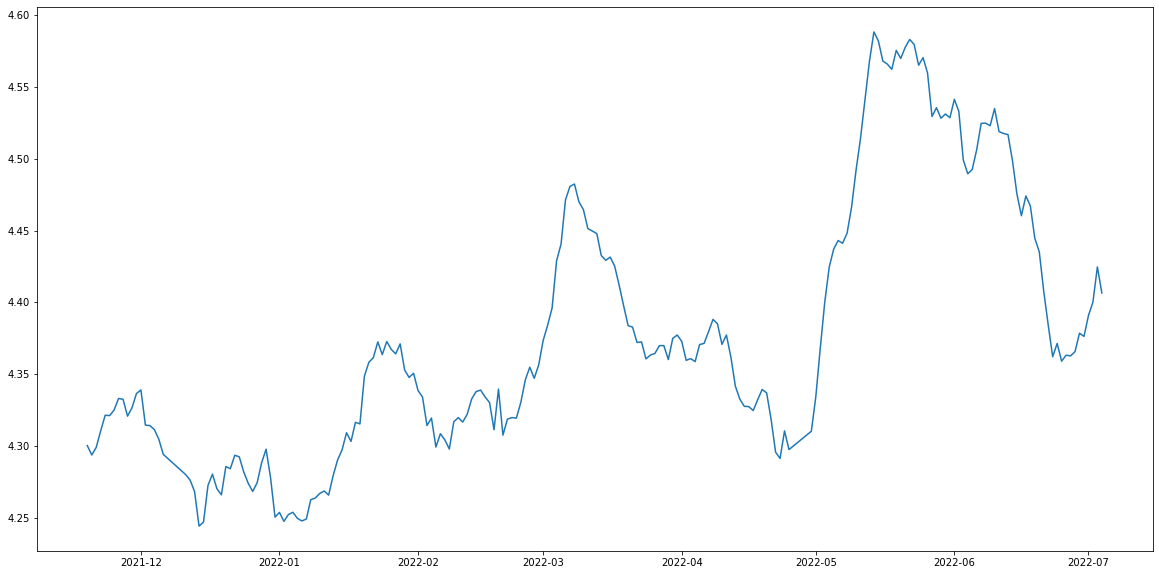

In [108]:
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(target_overall["target"].rolling(window=14).mean().dropna());

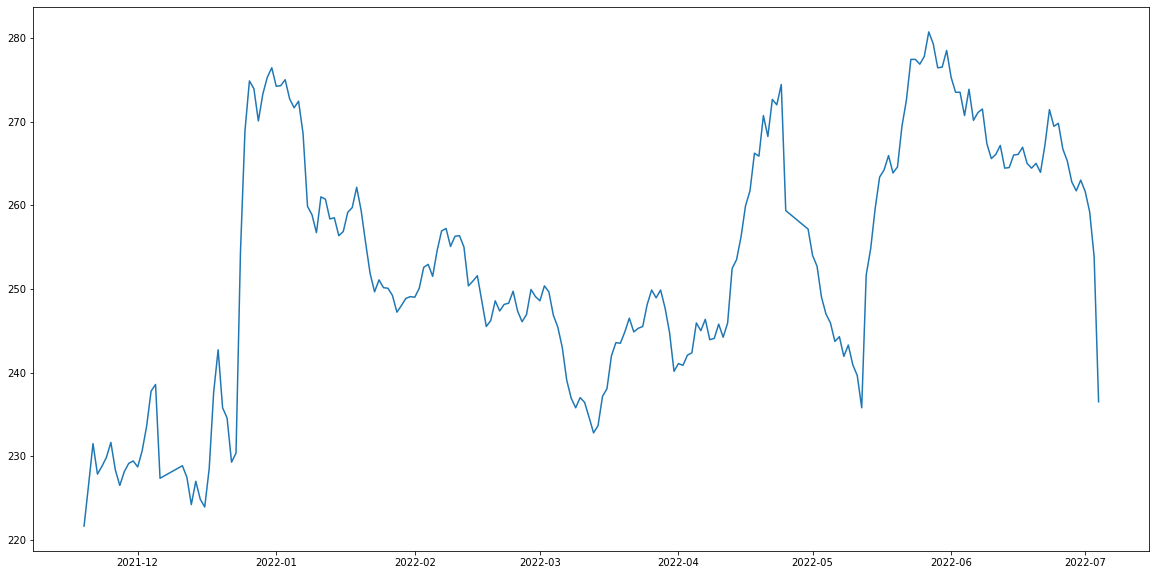

In [107]:
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(target_overall["url"].rolling(window=14).mean().dropna());

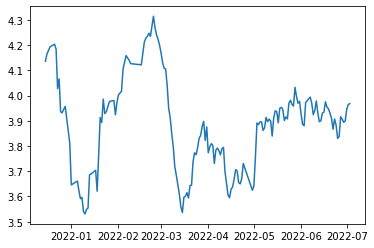

In [83]:
plt.plot(tsdf[tsdf.subreddit=="beagles"].target.rolling(window=14).mean().dropna(),label=sub)

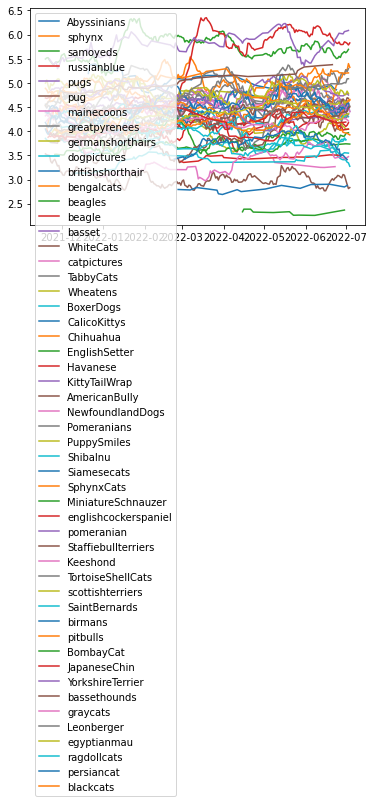

In [75]:
for sub in tsdf.subreddit.unique():
    
    plt.plot(tsdf[tsdf.subreddit==sub].target.rolling(window=14).mean().dropna(),label=sub)
    
plt.legend()

In [70]:
tsdf.subscribers_logged.rolling(window=7).mean().dropna()

date
2021-11-06    10.201376
2021-11-06    10.492431
2021-11-06    10.197173
2021-11-06    10.471540
2021-11-06    10.525928
                ...    
2022-07-04    10.720536
2022-07-04    10.508507
2022-07-04    10.221218
2022-07-04    10.085710
2022-07-04    10.107791
Name: subscribers_logged, Length: 7494, dtype: float64